# 衛星データのセマンティックセグメンテーション（AWS Open Data / STAC API）  
# Semantic Segmentation with Satellite Data (AWS Open Data / STAC API)

**概要 / Overview**  
このGoogle Colabノートブックでは、**AWS Open Data**上の**Sentinel‑2 L2A Cloud‑Optimized GeoTIFF (COG)** を、**STAC API (Earth Search v1)** 経由で検索・取得し、NDVIに基づくルールベースのセマンティックセグメンテーション（植生・水域・その他）を実施します。必要に応じて、擬似ラベルを用いた簡易U‑Net学習のオプションも含めます。  
In this Google Colab notebook, we query **Sentinel‑2 L2A Cloud‑Optimized GeoTIFF (COG)** on **AWS Open Data** via the **STAC API (Earth Search v1)**, then perform rule‑based semantic segmentation (vegetation / water / other) using NDVI. An optional quick U‑Net training section with pseudo‑labels is also included.

**ポイント / Highlights**
- APIキー不要、無料の公開データのみ（Earth Search / Registry of Open Data on AWS）  
  No API keys, using free public data only (Earth Search / AWS Registry of Open Data).  
- STAC検索でAOI・日付・雲量を指定  
  Filter by AOI, date, and cloud cover via STAC search.  
- COGから赤（B04）・近赤外（B08）を読み込み、NDVIで二値・多クラスマスク作成  
  Read Red (B04) & NIR (B08) bands from COGs to build binary/multi‑class masks via NDVI.

> 注 / Note: 本ノートはColab上で実行してください。ここでの`pip install`やHTTPアクセスはColabでは可能ですが、オフライン環境では動作しません。  
> Run this notebook in Colab. `pip install` and HTTP access are fine in Colab but won’t work offline.


## セットアップ / Setup
必要なライブラリをインストール・読み込みします。  
Install and import required libraries.


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/test


In [2]:

# If running in Colab, uncomment the next cell to install packages.
# Colab often ships with torch/torchvision preinstalled.

!pip -q install pystac-client rasterio shapely geopandas folium scikit-learn matplotlib

import os, json, math
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Polygon, mapping
from pystac_client import Client
import rasterio
from rasterio.plot import show
from rasterio.session import AWSSession

plt.rcParams['figure.figsize'] = (8,6)


## エリア・期間の指定 / Define Area of Interest (AOI) & Time Range
下記セルのパラメータを編集して、対象領域（緯度経度のポリゴン）と日付範囲、雲量上限を設定します。  
Edit the parameters in the next cell to set AOI (lat/lon polygon), date range, and max cloud cover.


In [3]:

# === User parameters ===
# AOI: a small box in Tokyo area as an example (edit as needed)
minx, miny = 139.70, 35.60  # lon, lat (lower-left)
maxx, maxy = 139.78, 35.66  # lon, lat (upper-right)

# Date range (ISO8601 interval)
DATE_FROM = (datetime.utcnow() - timedelta(days=365)).strftime('%Y-%m-%d')  # one year back
DATE_TO   = datetime.utcnow().strftime('%Y-%m-%d')
DATETIME  = f"{DATE_FROM}/{DATE_TO}"

# Max cloud cover (%)
MAX_CLOUD = 10

# Build GeoJSON polygon for intersects
polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
aoi_geojson = mapping(polygon)

# Quick map preview
m = folium.Map(location=[(miny+maxy)/2, (minx+maxx)/2], zoom_start=12)
folium.GeoJson(aoi_geojson, name='AOI').add_to(m)
print("AOI and parameters set. Scroll below for map.")
m


AOI and parameters set. Scroll below for map.


/tmp/ipython-input-828497003.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  DATE_FROM = (datetime.utcnow() - timedelta(days=365)).strftime('%Y-%m-%d')  # one year back
/tmp/ipython-input-828497003.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  DATE_TO   = datetime.utcnow().strftime('%Y-%m-%d')


## STAC検索（Earth Search v1） / STAC Search (Earth Search v1)
`pystac-client`を使って、Sentinel‑2 L2AコレクションからAOIに合致し雲量が小さいアイテムを取得します。  
Using `pystac-client`, fetch items from the Sentinel‑2 L2A collection matching AOI with low cloud cover.


In [4]:

EARTH_SEARCH = "https://earth-search.aws.element84.com/v1"
COLLECTION   = "sentinel-2-l2a"  # Earth Search v1 collection name

client = Client.open(EARTH_SEARCH)
search = client.search(
    collections=[COLLECTION],
    intersects=aoi_geojson,
    datetime=DATETIME,
    query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
    limit=10
)
items = list(search.get_items())
print(f"Found {len(items)} items in {COLLECTION} within AOI and cloud<{MAX_CLOUD}%.")

if not items:
    raise SystemExit("No items found. Try expanding date range or AOI, or increasing MAX_CLOUD.")

# Choose the first item
item = items[0]
print("Selected item id:", item.id)
print("Acquired:", item.properties.get('datetime'))

# Inspect available assets (bands)
print("Available asset keys:", list(item.assets.keys()))


/usr/local/lib/python3.12/dist-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 21 items in sentinel-2-l2a within AOI and cloud<10%.
Selected item id: S2B_54SUE_20251207_0_L2A
Acquired: 2025-12-07T01:37:19.013000Z
Available asset keys: ['aot', 'blue', 'cloud', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'product_metadata', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'snow', 'swir16', 'swir22', 'tileinfo_metadata', 'visual', 'wvp', 'thumbnail', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2']


## バンド読み込み（B04=赤, B08=近赤外） / Read Bands (B04=Red, B08=NIR)
COG（Cloud‑Optimized GeoTIFF）から赤（B04）と近赤外（B08）を読み込み、NDVIを計算します。  
Read Red (B04) and NIR (B08) bands from COGs and compute NDVI.

> NDVIは `(NIR - RED) / (NIR + RED)`。Sentinel‑2では `B08` と `B04` を用います。  
> NDVI = `(NIR - RED) / (NIR + RED)`, using Sentinel‑2 `B08` and `B04`.


In [5]:

# Get asset URLs
href_B04 = item.assets['red'].href
href_B08 = item.assets['nir'].href
print("B04 href:", href_B04)
print("B08 href:", href_B08)

# Read arrays
with rasterio.open(href_B04) as src_red:
    red = src_red.read(1).astype('float32')
    profile = src_red.profile
with rasterio.open(href_B08) as src_nir:
    nir = src_nir.read(1).astype('float32')

# Compute NDVI (robust to uniform scaling)
ndvi = (nir - red) / (nir + red + 1e-6)

# Basic stats
print("NDVI min/max:", float(np.nanmin(ndvi)), float(np.nanmax(ndvi)))


B04 href: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2025/12/S2B_54SUE_20251207_0_L2A/B04.tif
B08 href: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2025/12/S2B_54SUE_20251207_0_L2A/B08.tif
NDVI min/max: -1.0 1.0


## セマンティックセグメンテーション（しきい値） / Semantic Segmentation (Thresholds)
簡易ルール：  
- NDVI > 0.30 → **植生 / Vegetation**  
- NDVI < 0.05 → **水域 / Water**  
- その他 → **その他（市街地など） / Other (built‑up etc.)**

マスクを生成し、PNGとGeoTIFFで保存します。  
Generate mask and save as PNG and GeoTIFF.


Saved PNG: ndvi_and_segmentation.png
Saved GeoTIFF: segmentation_mask.tif


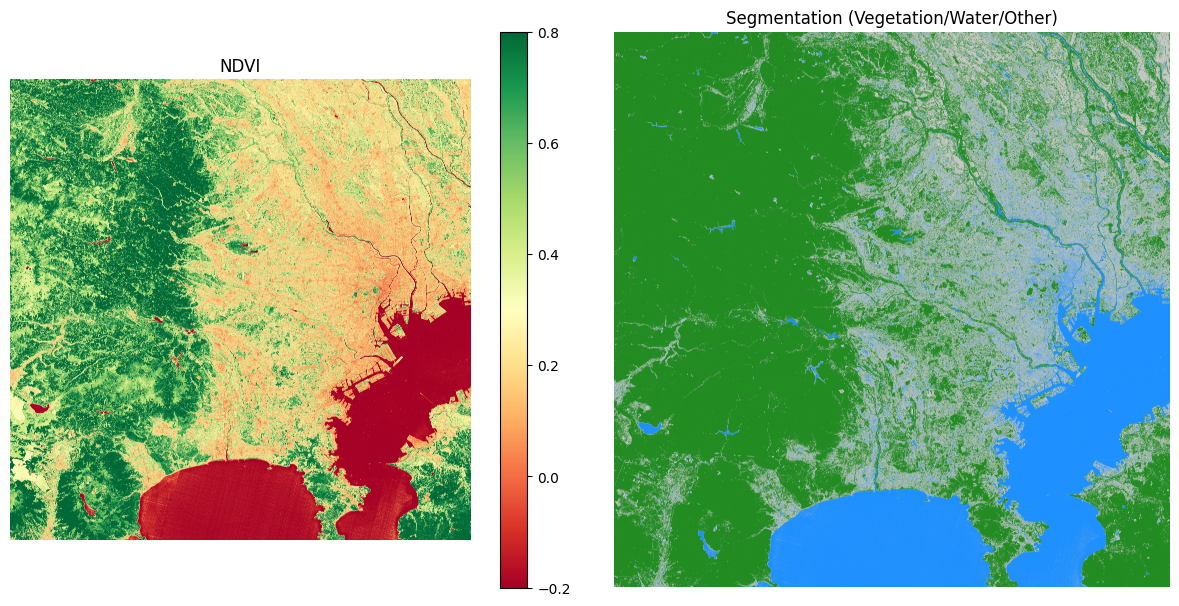

In [6]:

# Create multiclass mask: 0=other, 1=vegetation, 2=water
mask = np.zeros(ndvi.shape, dtype=np.uint8)
mask[(ndvi > 0.30)] = 1
mask[(ndvi < 0.05)] = 2

# Color map for visualization
cmap = {
    0: (200, 200, 200),  # other: light gray
    1: (34, 139, 34),    # vegetation: forest green
    2: (30, 144, 255),   # water: dodger blue
}

rgb = np.zeros((ndvi.shape[0], ndvi.shape[1], 3), dtype=np.uint8)
for cls, color in cmap.items():
    rgb[mask==cls] = color

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,6))
im0 = ax[0].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax[0].set_title('NDVI')
plt.colorbar(im0, ax=ax[0])
ax[1].imshow(rgb)
ax[1].set_title('Segmentation (Vegetation/Water/Other)')
for a in ax: a.axis('off')
plt.tight_layout()

# Save PNG
plt.savefig('ndvi_and_segmentation.png', dpi=200)
print('Saved PNG: ndvi_and_segmentation.png')

# Save GeoTIFF mask with original profile
out_profile = profile.copy()
out_profile.update({
    'dtype': 'uint8',
    'count': 1,
    'compress': 'deflate'
})
with rasterio.open('segmentation_mask.tif', 'w', **out_profile) as dst:
    dst.write(mask, 1)
print('Saved GeoTIFF: segmentation_mask.tif')
